In [61]:
# Прогнозирование количества посетителей ресторанов
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import warnings
warnings.filterwarnings('ignore')

In [63]:
# Чтение данных
air_reserve = pd.read_csv('air_reserve.csv')
hpg_reserve = pd.read_csv('hpg_reserve.csv')
air_store_info = pd.read_csv('air_store_info.csv')
hpg_store_info = pd.read_csv('hpg_store_info.csv')
air_visit_data = pd.read_csv('air_visit_data.csv')
date_info = pd.read_csv('date_info.csv')
store_id_relation = pd.read_csv('store_id_relation.csv')

In [64]:
# 2. Предварительная обработка данных

# Преобразование столбцов с датами
def convert_datetime(df, columns):
    for col in columns:
        df[col] = pd.to_datetime(df[col])
    return df

air_reserve = convert_datetime(air_reserve, ['visit_datetime', 'reserve_datetime'])
hpg_reserve = convert_datetime(hpg_reserve, ['visit_datetime', 'reserve_datetime'])
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date'])

# Создание дополнительных признаков для резервирования
def create_reserve_features(reserve_df):
    # Вычисление разницы между датой посещения и датой бронирования
    reserve_df['reserve_datetime_diff'] = (reserve_df['visit_datetime'] -
                                         reserve_df['reserve_datetime']).dt.total_seconds() / 3600

    # Извлечение дня недели и часа из datetime
    reserve_df['visit_datetime_dow'] = reserve_df['visit_datetime'].dt.dayofweek
    reserve_df['visit_datetime_hour'] = reserve_df['visit_datetime'].dt.hour

    return reserve_df

air_reserve = create_reserve_features(air_reserve)
hpg_reserve = create_reserve_features(hpg_reserve)


In [65]:
# 3. Создание признаков

# Первым делом преобразую все даты в правильный формат
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date']).dt.date
date_info['calendar_date'] = pd.to_datetime(date_info['calendar_date']).dt.date

# Агрегация данных о бронировании
def aggregate_reservations(reserve_df, store_id_col):
    # Преобразую datetime в date при группировке
    reserve_visited = reserve_df.groupby([store_id_col,
                                        reserve_df['visit_datetime'].dt.date]).agg({
        'reserve_visitors': 'sum',
        'reserve_datetime_diff': 'mean'
    }).reset_index()

    reserve_visited.columns = [store_id_col, 'visit_date',
                             'reserve_visitors_sum', 'reserve_datetime_diff_mean']
    return reserve_visited

air_reserve_agg = aggregate_reservations(air_reserve, 'air_store_id')
hpg_reserve_agg = aggregate_reservations(hpg_reserve, 'hpg_store_id')

# Объединение всех данных
def merge_data(air_visit_data, air_reserve_agg, date_info, air_store_info):
    # Объединяю с данными о бронировании
    df = pd.merge(air_visit_data, air_reserve_agg,
                 how='left', on=['air_store_id', 'visit_date'])

    # Объединяю с информацией о датах
    df = pd.merge(df, date_info, how='left',
                 left_on='visit_date', right_on='calendar_date')

    # Объединяю с информацией о ресторанах
    df = pd.merge(df, air_store_info, how='left', on='air_store_id')

    # Заполняю пропущенные значения
    df = df.fillna({
        'reserve_visitors_sum': 0,
        'reserve_datetime_diff_mean': 0
    })

    return df

# Создаю итоговый датасет
final_df = merge_data(air_visit_data, air_reserve_agg, date_info, air_store_info)

# Проверяю результат
print("Форма итогового датафрейма:", final_df.shape)
print("\nПервые несколько строк:")
print(final_df.head())
print("\nТипы данных в столбцах:")
print(final_df.dtypes)

Форма итогового датафрейма: (252108, 12)

Первые несколько строк:
           air_store_id  visit_date  visitors  reserve_visitors_sum  \
0  air_ba937bf13d40fb24  2016-01-13        25                   0.0   
1  air_ba937bf13d40fb24  2016-01-14        32                   0.0   
2  air_ba937bf13d40fb24  2016-01-15        29                   0.0   
3  air_ba937bf13d40fb24  2016-01-16        22                   0.0   
4  air_ba937bf13d40fb24  2016-01-18         6                   0.0   

   reserve_datetime_diff_mean calendar_date day_of_week  holiday_flg  \
0                         0.0    2016-01-13   Wednesday            0   
1                         0.0    2016-01-14    Thursday            0   
2                         0.0    2016-01-15      Friday            0   
3                         0.0    2016-01-16    Saturday            0   
4                         0.0    2016-01-18      Monday            0   

  air_genre_name                 air_area_name   latitude   longitude  
0 

In [66]:
# 4. Подготовка данных для обучения

# Кодирование категориальных переменных
le = LabelEncoder()
final_df['air_genre_name_encoded'] = le.fit_transform(final_df['air_genre_name'])
final_df['air_area_name_encoded'] = le.fit_transform(final_df['air_area_name'])
final_df['day_of_week_encoded'] = le.fit_transform(final_df['day_of_week'])

# Создание признаков для обучения
features = ['air_genre_name_encoded', 'air_area_name_encoded', 'day_of_week_encoded',
           'holiday_flg', 'reserve_visitors_sum', 'reserve_datetime_diff_mean']

X = final_df[features]
y = final_df['visitors']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [67]:
# Импортируем GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Обучение модели
gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)
gbr.fit(X_train, y_train)

# Прогнозирование
y_pred = gbr.predict(X_test)

# Оценка качества модели
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 204.46
MAE: 10.20
RMSE: 14.30


In [68]:
# Важность признаков
feature_importances = pd.DataFrame({
    "Feature": features,
    "Importance": gbr.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nВажность признаков:")
print(feature_importances)


Важность признаков:
                      Feature  Importance
1       air_area_name_encoded    0.295880
4        reserve_visitors_sum    0.266016
0      air_genre_name_encoded    0.235971
2         day_of_week_encoded    0.164624
5  reserve_datetime_diff_mean    0.024584
3                 holiday_flg    0.012926


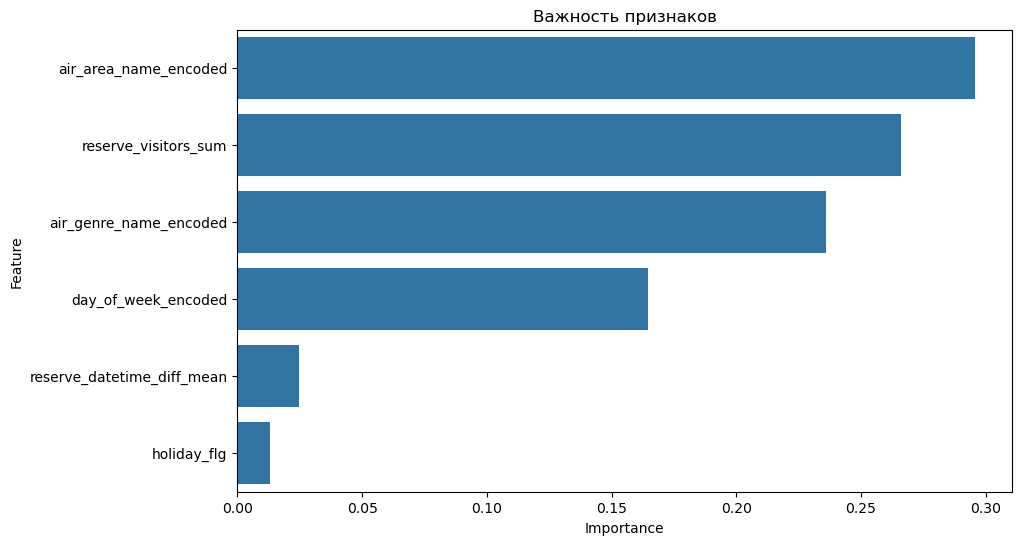

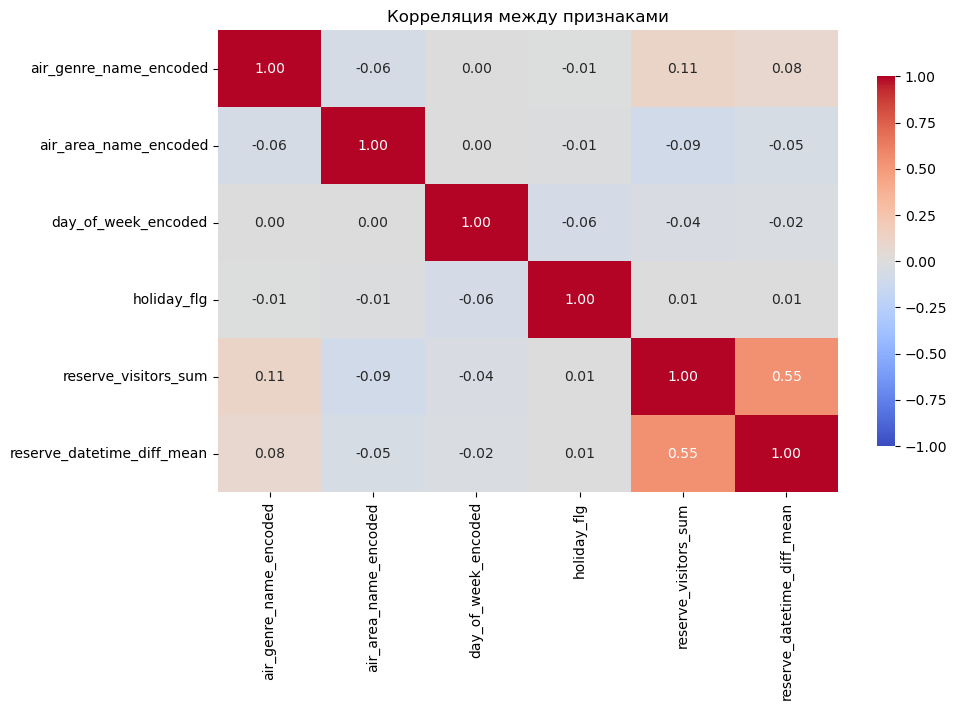

In [78]:
# Визуализация важности признаков
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importances)
plt.title("Важность признаков")
plt.show()
corr_features = final_df[features]

# Вычисление корреляционной матрицы
corr_matrix = corr_features.corr()

# Построение тепловой карты
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={'shrink': 0.8})
plt.title('Корреляция между признаками')
plt.show()

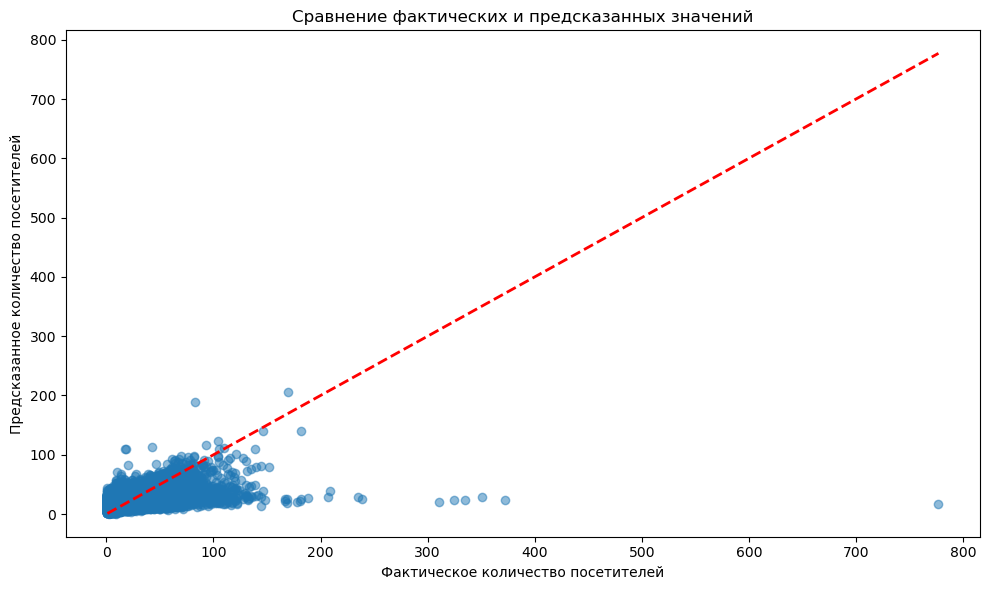

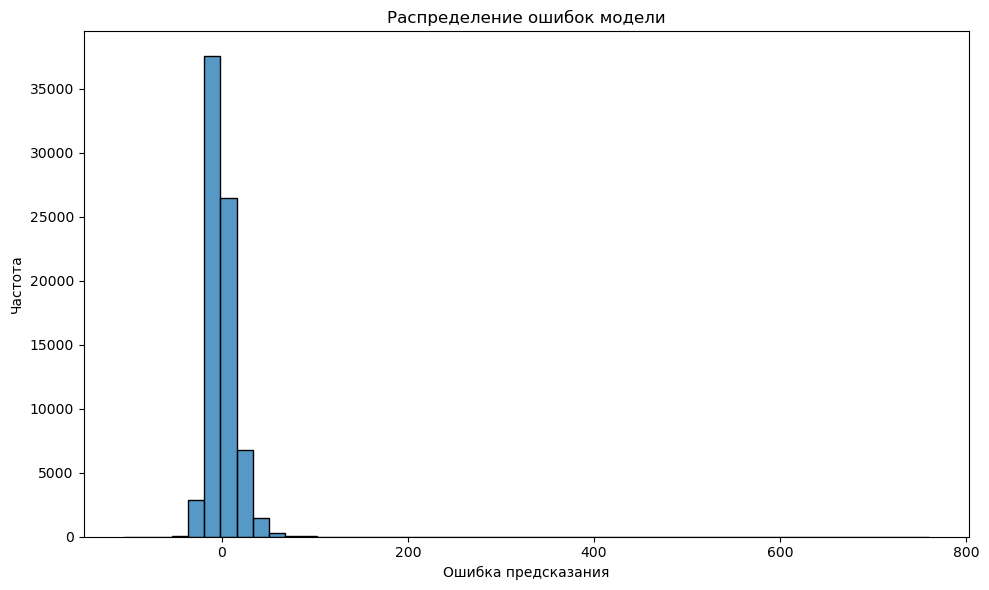

In [71]:
# График фактических и предсказанных значений
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)   
plt.xlabel('Фактическое количество посетителей')
plt.ylabel('Предсказанное количество посетителей')
plt.title('Сравнение фактических и предсказанных значений')
plt.tight_layout()
plt.show()

# График распределения ошибок
plt.figure(figsize=(10, 6))
errors = y_test - y_pred
sns.histplot(errors, bins=50)
plt.title('Распределение ошибок модели')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()